## functions

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global ny, N, a1
ny = 10 # unit cell number in y direction
N = 2*ny
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    E = np.real(E)
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = np.linalg.eig(H)
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag
    # return E

def hamiltonian_0(j, J, d, h, k):
    ''' H in A, B basis
    '''
    
    ni = lambda i: i % N
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    phase = np.exp(1j * k * a1)
    Pnn = j*(phase + 1/phase)
    Pnnn = J*(phase + 1/phase)
    Pd = 1j*d*(phase - 1/phase)
    
    mat = np.eye(N, dtype=np.complex64) * (3*j+6*J+h + J*(phase**2+1/(phase**2)))
    
    for i in A:
        
        mat[ni(i), ni(i+1)] += Pnn
        mat[ni(i), ni(i-1)] += j 
        
        mat[ni(i), ni(i+2)] += (Pnnn + Pd)
        mat[ni(i), ni(i-2)] += (Pnnn + Pd)
        mat[ni(i+2), ni(i)] += (Pnnn + Pd)
        mat[ni(i-2), ni(i)] += (Pnnn + Pd)
        mat[ni(i), ni(i)] -= 1j*d*(phase**2 - 1/(phase**2))
        
    for i in B: 
        
        mat[ni(i), ni(i+1)] += j
        mat[ni(i), ni(i-1)] += Pnn
        
        mat[ni(i), ni(i+2)] += (Pnnn - Pd)
        mat[ni(i), ni(i-2)] += (Pnnn - Pd)
        mat[ni(i+2), ni(i)] += (Pnnn - Pd)
        mat[ni(i-2), ni(i)] += (Pnnn - Pd)
        mat[ni(i), ni(i)] += 1j*d*(phase**2 - 1/(phase**2))
        
    # boundary condition
    
    i = 0
    mat[ni(i), ni(i-1)] = 0
    mat[ni(i), ni(i-2)] = 0
    
    i = 1
    mat[ni(i), ni(i-2)] = 0
    
    i = N-2
    mat[ni(i), ni(i+2)] = 0
    
    i = N-1
    mat[ni(i), ni(i+1)] = 0
    mat[ni(i), ni(i+2)] = 0

    return mat/2

def hamiltonian_mft(iteration, T, jn, J, d, h, kx, txtout=None):
    ''' H in u, d basis
    '''
    
    K = kx*a1
    
    H_0 = hamiltonian_0(jn, J, d, h, kx)
    E, U, U_dag = eigenv(H_0) # 1st order eigenvalues and eigenvectors
    
    Ei = np.sort(E)
    if txtout is not None:
        with open(txtout, 'w') as f:
            for i in range(N):
                f.write(f'E{i},')
            f.write('\n')
            for i in range(N):
                f.write(f'{np.real(Ei[i])},')
            f.write('\n')
    
    H_1 = np.zeros((N, N), dtype=np.complex64)
    H_1 += U_dag @ H_0 @ U # 1st order H in u, d basis
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    for iter in range(iteration):
        
        def V(m, n, i, j):
            if i < 0 or i >= N or j < 0 or j >= N:
                return 0 # OBC
            else: return U_dag[m, i] * U[j, n]
        
        N_b = 0
        for i in range(N):
            N_b += NB(T, E[i]) / N
        print(f'Number of bosons per site: {N_b}')
        
        for m in range(N):
            for n in range(N):
                
                for a in A:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,a,a-1) + V(m,n,a-1,a) - V(m,n,a-1,a-1) - V(m,n,a,a))
                    H_1[m, n] += (jn*N_b) * (V(m,n,a,a+1) + V(m,n,a+1,a) - V(m,n,a+1,a+1) - V(m,n,a,a)) * 2*np.cos(K)
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b) * (V(m,n,a,a-2)+V(m,n,a-2,a)-V(m,n,a-2,a-2)-V(m,n,a,a)) * 2*np.cos(K)
                    H_1[m, n] += (J*N_b) * (V(m,n,a,a+2)+V(m,n,a+2,a)-V(m,n,a+2,a+2)-V(m,n,a,a)) * 2*np.cos(K)
                    
                    # DMI terms
                    H_1[m, n] += (d*N_b) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * 2*np.sin(K)
                    
                for b in B:
                    # NN terms
                    H_1[m, n] += (jn*N_b) * (V(m,n,b,b-1) + V(m,n,b-1,b) - V(m,n,b-1,b-1) - V(m,n,b,b)) * 2*np.cos(K)
                    H_1[m, n] += (jn*N_b) * (V(m,n,b,b+1) + V(m,n,b+1,b) - V(m,n,b+1,b+1) - V(m,n,b,b))
                    
                    # NNN terms
                    H_1[m, n] += (J*N_b) * (V(m,n,b,b-2)+V(m,n,b-2,b)-V(m,n,b-2,b-2)-V(m,n,b,b)) * 2*np.cos(K)
                    H_1[m, n] += (J*N_b) * (V(m,n,b,b+2)+V(m,n,b+2,b)-V(m,n,b+2,b+2)-V(m,n,b,b)) * 2*np.cos(K)
                    
                    # DMI terms
                    H_1[m, n] -= (d*N_b) * (V(m,n,b,b-2)-V(m,n,b-2,b)+V(m,n,b,b+2)-V(m,n,b+2,b)) * 2*np.sin(K)
        
        H_D = U @ H_1 @ U_dag # back to A, B basis
        E, U, U_dag = eigenv(H_D)
        H_1 = U_dag @ H_0 @ U # reset H_1 for next iteration
        print(f'det(UUdagger)={np.linalg.det(U@U_dag)}')
        
        Ei = np.sort(E)
        if txtout is not None:
            with open(txtout, 'a') as f:
                for i in range(N):
                    f.write(f'{np.real(Ei[i])},')
                f.write('\n')
    
        print(f'Iteration {iter} finished.')
        
        # with open(f'./H{T}{jn}{J}{d}.txt', 'a') as f:
        #     f.write(f'Iteration {iter} H matrix:\n')
        #     for i in range(N):
        #         for j in range(N):
        #             f.write('{0:.4f},'.format(np.real(H[i, j])))
        #         f.write('\n')
    
    return E

## 2nd order

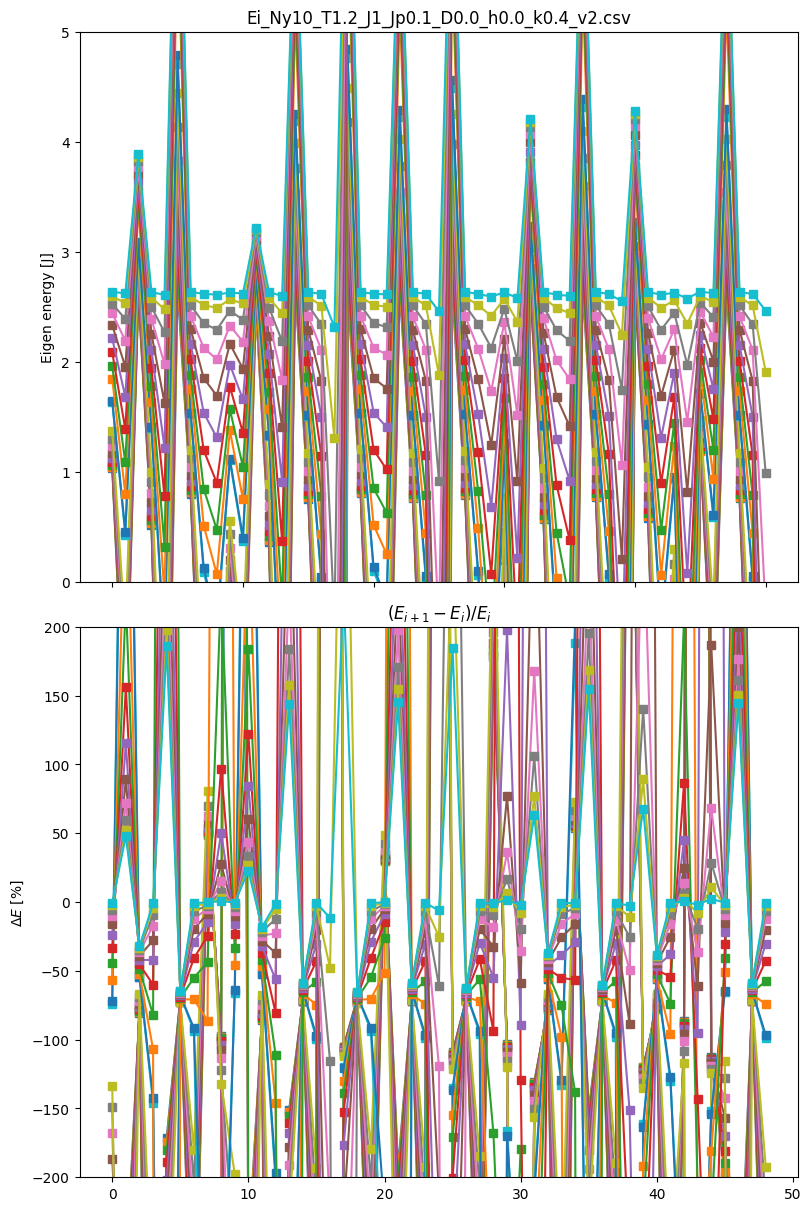

In [104]:
file = f'Ei_Ny{10}_T{1.2}_J{1}_Jp{0.1}_D{0.0}_h{0.0}_k{0.4}_v2.csv'
iterations = 50

fig, axs = plt.subplots(2, 1, figsize=(8, 12), layout='constrained')

data = pd.read_csv('./data/' + file)

ax = axs[0]
for i in range(len(data.columns)):
    ax.plot(data.iloc[:, i], label=f'E{i}', marker='s')
    
ax.set_ylim(0, 5)
ax.set_ylabel('Eigen energy [J]')
ax.label_outer()
ax.set_title(file)

ax = axs[1]
for i in range(len(data.columns)):
    delta = []
    for j in range(iterations-1):
        delta.append(100*(data.iloc[j+1, i]-data.iloc[j, i])/data.iloc[j, i])
    ax.plot(delta, label=f'E{i}', marker='s')

ax.set_ylim(-200, 200)
ax.set_ylabel('$\Delta E$ [%]')
ax.set_title('$(E_{i+1} - E_i)/E_i$')

plt.savefig(f'./louvre/{file[:-4]}_v2.png', dpi=100)
plt.show()

In [102]:
j = 1
J = 0.1
D = 0.
h = 0.0
T = 1.2

iter = 50

k = 0.4
K = k*np.pi/a1

file = f'./data/Ei_Ny{ny}_T{T}_J{j}_Jp{J}_D{D}_h{h}_k{k}_v2.csv'

hamiltonian_mft(iter, T, j, J, D, h, K, txtout=file)
# hamiltonian_mft(3, T, j, J, D, h, K)

Number of bosons per site: 0.3953506157870278
det(UUdagger)=(0.9999999999999988+2.040942361666324e-32j)
Iteration 0 finished.
Number of bosons per site: -0.4418029994603044
det(UUdagger)=(1.0000000000000002+2.85085920833447e-31j)
Iteration 1 finished.
Number of bosons per site: 0.08077945503865852
det(UUdagger)=(1-2.3378553545658644e-31j)
Iteration 2 finished.
Number of bosons per site: 0.7428814417847215
det(UUdagger)=(1-3.445258921286917e-33j)
Iteration 3 finished.
Number of bosons per site: -0.9958057124813103
det(UUdagger)=(1+5.477329344442902e-34j)
Iteration 4 finished.
Number of bosons per site: 0.036103203168200836
det(UUdagger)=(0.9999999999999994+2.2585041747189405e-34j)
Iteration 5 finished.
Number of bosons per site: 0.5044231667052953
det(UUdagger)=(1.0000000000000009-4.69353406286958e-33j)
Iteration 6 finished.
Number of bosons per site: 0.67239003202771
det(UUdagger)=(1.0000000000000004-8.734857983859236e-34j)
Iteration 7 finished.
Number of bosons per site: 0.17614514899

array([  2.46635522-7.61270246e-17j,   1.91097857-7.14044732e-17j,
         0.99130375-6.36788849e-17j,  -0.27445678-5.31691747e-17j,
        -1.84970793-4.01662985e-17j,  -3.67769025-2.49740027e-17j,
        -5.68192649-7.76928001e-18j,  -7.76337883+1.16969693e-17j,
        -9.78008628+3.48900271e-17j, -11.76739308+4.70464981e-17j,
       -12.07556191+6.33815461e-17j, -19.10709926-1.89211076e-17j,
       -20.46047486+1.21557251e-18j, -21.96069804+1.49635061e-17j,
       -23.3831287 +2.35490527e-17j, -24.64095749+2.86685672e-17j,
       -27.47893001+3.33144375e-17j, -27.12035703+3.32368249e-17j,
       -26.52420114+3.27787801e-17j, -25.69454798+3.14684648e-17j])